In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import json

import sys
import os
sys.path.append("/zhouxibin/workspaces/mutation")
from utils.rank import rank_strategy_dictionary
from utils.model import model_name_library
from utils.pipeline import read_sequence
from utils.metrics import read_dms_file

/zhouxibin/anaconda3/envs/mutations/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# compute random converage
dms_dir = "../data/dms"
sequence_dir = Path(dms_dir) / "fasta"
gt_dir = Path(dms_dir) / "dms"
results_dir = Path(dms_dir) / "results"

In [5]:
# get all sequence names
sequence_names = [g.stem for g in sequence_dir.glob("*.fa")]

In [54]:
from itertools import product
from tqdm import tqdm
random_precision_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    for model_name, rank_strategy in product(model_name_library, rank_strategy_dictionary.keys()):
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        if result_file.exists():
            result_df = pd.read_csv(result_file)
            selected_number = max([(result_df["fitness"] > 0).sum(), 50])
            selected_rate = selected_number / result_df.shape[1]
            mean_precision = []
            for i in range(10):
                # random select selected_number in result_df
                random_df = result_df.sample(n=selected_number, random_state=i)
                # merge random_df and dms_df
                merged_df = random_df.merge(dms_df, on="sequence", suffixes=("_random", "_dms"))
                precision = (merged_df["fitness_dms"]>wt_fitness).sum() / random_df.shape[0]
                mean_precision.append(precision)
            precision = np.mean(mean_precision)
            random_precision_list.append((sequence_name, model_name, rank_strategy, precision))

100%|██████████| 542/542 [34:05<00:00,  3.77s/it]


In [55]:
random_precision_df = pd.DataFrame(random_precision_list, columns=["sequence", "model", "rank_strategy", "precision"])
random_precision_df.to_csv(Path("/zhouxibin/workspaces/mutations") / "random_precision.csv", index=False)

In [8]:
random_precision_df = pd.read_csv(Path("/zhouxibin/workspaces/mutation") / "random_precision.csv")

In [9]:
random_precision_df

,sequence,model,rank_strategy,precision
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,0.384249
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,0.392000
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,0.378000
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,0.384746
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,0.367742
...,...,...,...,...
79259,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_4,0.178740
79260,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_5,0.170000
79261,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_1,0.179423
79262,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_4,0.180405


In [11]:
# load coverage
coverage_df = pd.read_csv(Path("/zhouxibin/workspaces/mutation") / "coverage.csv")
coverage_df

,sequence,model,rank_strategy,accuracy,precision,recall,f1
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,0.579078,0.500000,0.402367,0.445902
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,0.625156,0.877551,0.127219,0.222222
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,0.627646,0.897959,0.130178,0.227390
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,0.621420,0.646552,0.221893,0.330396
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,0.632628,0.852459,0.153846,0.260652
...,...,...,...,...,...,...,...
79259,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_4,0.342294,0.200226,0.867647,0.325368
79260,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_5,0.799283,0.300000,0.073529,0.118110
79261,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_1,0.499104,0.142857,0.348039,0.202568
79262,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_4,0.327957,0.207709,0.950980,0.340949


In [14]:
# merge coverage and random_precision
merged_df = coverage_df.merge(random_precision_df, on=["sequence", "model", "rank_strategy"], suffixes=["_rational", "_random"])
merged_df

,sequence,model,rank_strategy,accuracy,precision_rational,recall,f1,precision_random
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,0.579078,0.500000,0.402367,0.445902,0.384249
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,0.625156,0.877551,0.127219,0.222222,0.392000
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,0.627646,0.897959,0.130178,0.227390,0.378000
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,0.621420,0.646552,0.221893,0.330396,0.384746
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,0.632628,0.852459,0.153846,0.260652,0.367742
...,...,...,...,...,...,...,...,...
79259,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_4,0.342294,0.200226,0.867647,0.325368,0.178740
79260,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_5,0.799283,0.300000,0.073529,0.118110,0.170000
79261,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_1,0.499104,0.142857,0.348039,0.202568,0.179423
79262,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_4,0.327957,0.207709,0.950980,0.340949,0.180405


/tmp/ipykernel_1260/2235573734.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  per_model_strategy_group = per_model_strategy_group.mean().sort_values(by="precision_rational", ascending=False)


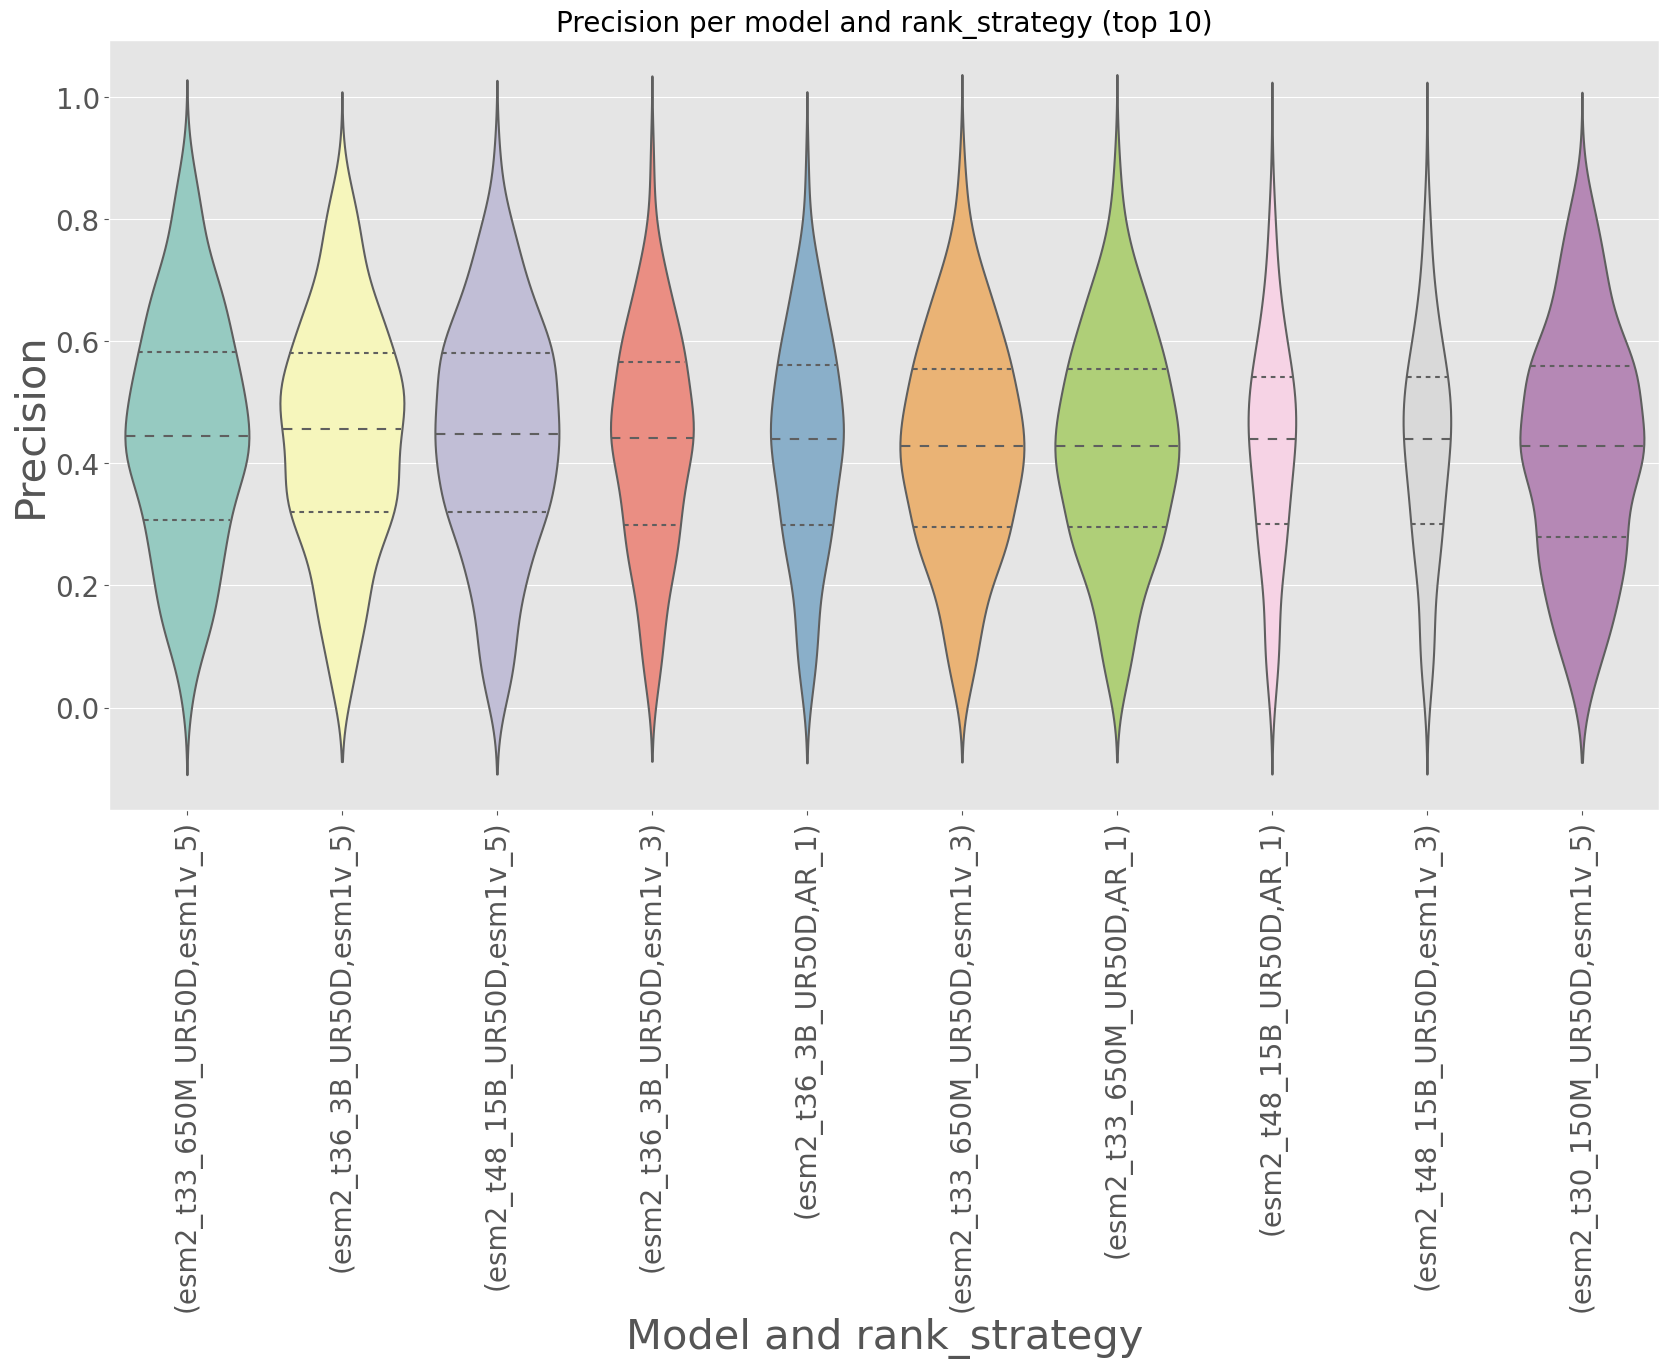

In [29]:
per_model_strategy_group = merged_df.groupby(["model", "rank_strategy"])
per_model_strategy_group = per_model_strategy_group.mean().sort_values(by="precision_rational", ascending=False)
# print(per_model_strategy_group.index.map(lambda x:x[0]))
per_model_strategy_group["plot_x"] = "("+per_model_strategy_group.index.map(lambda x:x[0])+","+per_model_strategy_group.index.map(lambda x:x[1])+")"
merged_df["plot_x"] = "("+merged_df["model"]+","+merged_df["rank_strategy"]+")"
plt.style.use("ggplot")

# plot violin for precision_folds
fig, ax = plt.subplots(figsize=(20, 10))

sns.violinplot(merged_df, x="plot_x", y="precision_rational", split=True, inner="quartile", palette="Set3", scale="count", scale_hue=False, ax=ax, order=per_model_strategy_group["plot_x"].values[:10])
# xticks rotate 90
plt.xticks(rotation=90, fontsize=20)
plt.xlabel("Model and rank_strategy", fontsize=30)
plt.ylabel("Precision", fontsize=30)
plt.yticks(fontsize=20)
plt.title("Precision per model and rank_strategy (top 10)", fontsize=20)
plt.savefig("3_figs/precision_per_model_strategy_violin.png", bbox_inches='tight')
plt.savefig("3_figs/precision_per_model_strategy_violin.pdf", bbox_inches='tight')


In [20]:
merged_df["precision_folds"] = merged_df["precision_rational"] / merged_df["precision_random"]
merged_df

,sequence,model,rank_strategy,accuracy,precision_rational,recall,f1,precision_random,plot_x,precision_folds
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,0.579078,0.500000,0.402367,0.445902,0.384249,"(esm1_t34_670M_UR50S,esm1v_1)",1.301239
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,0.625156,0.877551,0.127219,0.222222,0.392000,"(esm1_t34_670M_UR50S,esm1v_2)",2.238651
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,0.627646,0.897959,0.130178,0.227390,0.378000,"(esm1_t34_670M_UR50S,esm1v_3)",2.375553
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,0.621420,0.646552,0.221893,0.330396,0.384746,"(esm1_t34_670M_UR50S,esm1v_4)",1.680465
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,0.632628,0.852459,0.153846,0.260652,0.367742,"(esm1_t34_670M_UR50S,esm1v_5)",2.318090
...,...,...,...,...,...,...,...,...,...,...
79259,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_4,0.342294,0.200226,0.867647,0.325368,0.178740,"(esm2_t36_3B_UR50D,esm1v_4)",1.120209
79260,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_5,0.799283,0.300000,0.073529,0.118110,0.170000,"(esm2_t36_3B_UR50D,esm1v_5)",1.764706
79261,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_1,0.499104,0.142857,0.348039,0.202568,0.179423,"(esm2_t48_15B_UR50D,esm1v_1)",0.796203
79262,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_4,0.327957,0.207709,0.950980,0.340949,0.180405,"(esm2_t48_15B_UR50D,esm1v_4)",1.151349


In [21]:
new_rank_strategy_dictionary = {
    'esm1v_1': 'Masked Marginal Probability Strategy A',
    'esm1v_2': 'Masked Marginal Probability Strategy B',
    'esm1v_3': 'Masked Marginal Probability Strategy C',
    'esm1v_4': 'Mutant Marginal Probability',
    'esm1v_5': 'Wildtype Marginal Probability',
    'AR_1': 'Auto Regressive Strategy A',
    'AR_2': 'Auto Regressive Strategy B',
    'AR_3': 'Auto Regressive Strategy C',
    'AR_4': 'Auto Regressive Strategy D',
 }

In [24]:
plt.style.use("ggplot")
merged_df_for_group = merged_df["rank_strategy"].apply(lambda x:new_rank_strategy_dictionary[x])
merged_df_for_group = merged_df.assign(rank_strategy=merged_df_for_group)
per_model_strategy_group = merged_df_for_group.groupby(["model", "rank_strategy"])
per_model_strategy_group = per_model_strategy_group.mean().sort_values(by="precision_folds", ascending=False)
per_model_strategy_group.rename(columns={"precision_folds": "precision_folds(precision_rational/precision_random)"}, inplace=True)
per_model_strategy_group.loc[:, ["precision_rational", "precision_random", "precision_folds(precision_rational/precision_random)"]].to_csv(Path("/zhouxibin/workspaces/mutation") / "precision_folds.csv")
# per_model_strategy_group["precision_folds"].plot(kind="bar", title="Precision folds per model and rank_strategy", figsize=(30, 10), grid=True)
# plt.legend(loc='upper left')
# plt.savefig("3_figs/precisionfolds_per_model_strategy.png", bbox_inches='tight')
# plt.savefig("3_figs/precisionfolds_per_model_strategy.pdf", bbox_inches='tight')


/tmp/ipykernel_1260/3774736328.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  per_model_strategy_group = per_model_strategy_group.mean().sort_values(by="precision_folds", ascending=False)


In [25]:
merged_df["plot_x"] = "("+merged_df["model"]+","+merged_df["rank_strategy"]+")"

In [26]:
merged_df

,sequence,model,rank_strategy,accuracy,precision_rational,recall,f1,precision_random,plot_x,precision_folds
0,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_1,0.579078,0.500000,0.402367,0.445902,0.384249,"(esm1_t34_670M_UR50S,esm1v_1)",1.301239
1,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_2,0.625156,0.877551,0.127219,0.222222,0.392000,"(esm1_t34_670M_UR50S,esm1v_2)",2.238651
2,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_3,0.627646,0.897959,0.130178,0.227390,0.378000,"(esm1_t34_670M_UR50S,esm1v_3)",2.375553
3,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_4,0.621420,0.646552,0.221893,0.330396,0.384746,"(esm1_t34_670M_UR50S,esm1v_4)",1.680465
4,2BTH.pdb,esm1_t34_670M_UR50S,esm1v_5,0.632628,0.852459,0.153846,0.260652,0.367742,"(esm1_t34_670M_UR50S,esm1v_5)",2.318090
...,...,...,...,...,...,...,...,...,...,...
79259,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_4,0.342294,0.200226,0.867647,0.325368,0.178740,"(esm2_t36_3B_UR50D,esm1v_4)",1.120209
79260,1PGX.pdb,esm2_t36_3B_UR50D,esm1v_5,0.799283,0.300000,0.073529,0.118110,0.170000,"(esm2_t36_3B_UR50D,esm1v_5)",1.764706
79261,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_1,0.499104,0.142857,0.348039,0.202568,0.179423,"(esm2_t48_15B_UR50D,esm1v_1)",0.796203
79262,1PGX.pdb,esm2_t48_15B_UR50D,esm1v_4,0.327957,0.207709,0.950980,0.340949,0.180405,"(esm2_t48_15B_UR50D,esm1v_4)",1.151349


In [27]:
per_model_strategy_group = merged_df.groupby(["model", "rank_strategy"])
per_model_strategy_group = per_model_strategy_group.mean().sort_values(by="precision_folds", ascending=False)
# print(per_model_strategy_group.index.map(lambda x:x[0]))
per_model_strategy_group["plot_x"] = "("+per_model_strategy_group.index.map(lambda x:x[0])+","+per_model_strategy_group.index.map(lambda x:x[1])+")"
per_model_strategy_group

/tmp/ipykernel_1260/971950063.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  per_model_strategy_group = per_model_strategy_group.mean().sort_values(by="precision_folds", ascending=False)


accuracy  precision_rational    recall  \
model                  rank_strategy                                           
esm2_t33_650M_UR50D    esm1v_5        0.779646            0.449921  0.119370   
esm2_t36_3B_UR50D      esm1v_5        0.778958            0.443716  0.115042   
esm2_t48_15B_UR50D     esm1v_5        0.778709            0.443427  0.113664   
esm2_t30_150M_UR50D    esm1v_5        0.776877            0.422529  0.112557   
esm2_t36_3B_UR50D      esm1v_3        0.764170            0.432143  0.224976   
...                                        ...                 ...       ...   
                       esm1v_1        0.519801            0.201349  0.409768   
esm1v_t33_650M_UR90S_4 esm1v_1        0.492564            0.196748  0.433610   
esm2_t33_650M_UR50D    esm1v_1        0.490645            0.191216  0.423763   
esm2_t48_15B_UR50D     esm1v_1        0.526082            0.188008  0.360308   
esm1v_t33_650M_UR90S_5 esm1v_1        0.492869            0.189015  0.404714   

                                            f1  precision_random  \
model                  rank_strategy                               
esm2_t33_650M_UR50D    esm1v_5        0.175642          0.207557   
esm2_t36_3B_UR50D      esm1v_5        0.169772          0.208627   
esm2_t48_15B_UR50D     esm1v_5        0.168819          0.208391   
esm2_t30_150M_UR50D    esm1v_5        0.165189          0.208472   
esm2_t36_3B_UR50D      esm1v_3        0.266462          0.206359   
...                                        ...               ...   
                       esm1v_1        0.256642          0.207692   
esm1v_t33_650M_UR90S_4 esm1v_1        0.259064          0.207742   
esm2_t33_650M_UR50D    esm1v_1        0.251632          0.207721   
esm2_t48_15B_UR50D     esm1v_1        0.234867          0.207768   
esm1v_t33_650M_UR90S_5 esm1v_1        0.246481          0.207732   

                                      precision_folds  \
model                  rank_strategy                    
esm2_t33_650M_UR50D    esm1v_5               2.405396   
esm2_t36_3B_UR50D      esm1v_5               2.377309   
esm2_t48_15B_UR50D     esm1v_5               2.321645   
esm2_t30_150M_UR50D    esm1v_5               2.284330   
esm2_t36_3B_UR50D      esm1v_3               2.276048   
...                                               ...   
                       esm1v_1               0.953577   
esm1v_t33_650M_UR90S_4 esm1v_1               0.916610   
esm2_t33_650M_UR50D    esm1v_1               0.909801   
esm2_t48_15B_UR50D     esm1v_1               0.890110   
esm1v_t33_650M_UR90S_5 esm1v_1               0.879127   

                                                                plot_x  
model                  rank_strategy                                    
esm2_t33_650M_UR50D    esm1v_5           (esm2_t33_650M_UR50D,esm1v_5)  
esm2_t36_3B_UR50D      esm1v_5             (esm2_t36_3B_UR50D,esm1v_5)  
esm2_t48_15B_UR50D     esm1v_5            (esm2_t48_15B_UR50D,esm1v_5)  
esm2_t30_150M_UR50D    esm1v_5           (esm2_t30_150M_UR50D,esm1v_5)  
esm2_t36_3B_UR50D      esm1v_3             (esm2_t36_3B_UR50D,esm1v_3)  
...                                                                ...  
                       esm1v_1             (esm2_t36_3B_UR50D,esm1v_1)  
esm1v_t33_650M_UR90S_4 esm1v_1        (esm1v_t33_650M_UR90S_4,esm1v_1)  
esm2_t33_650M_UR50D    esm1v_1           (esm2_t33_650M_UR50D,esm1v_1)  
esm2_t48_15B_UR50D     esm1v_1            (esm2_t48_15B_UR50D,esm1v_1)  
esm1v_t33_650M_UR90S_5 esm1v_1        (esm1v_t33_650M_UR90S_5,esm1v_1)  

[153 rows x 7 columns]

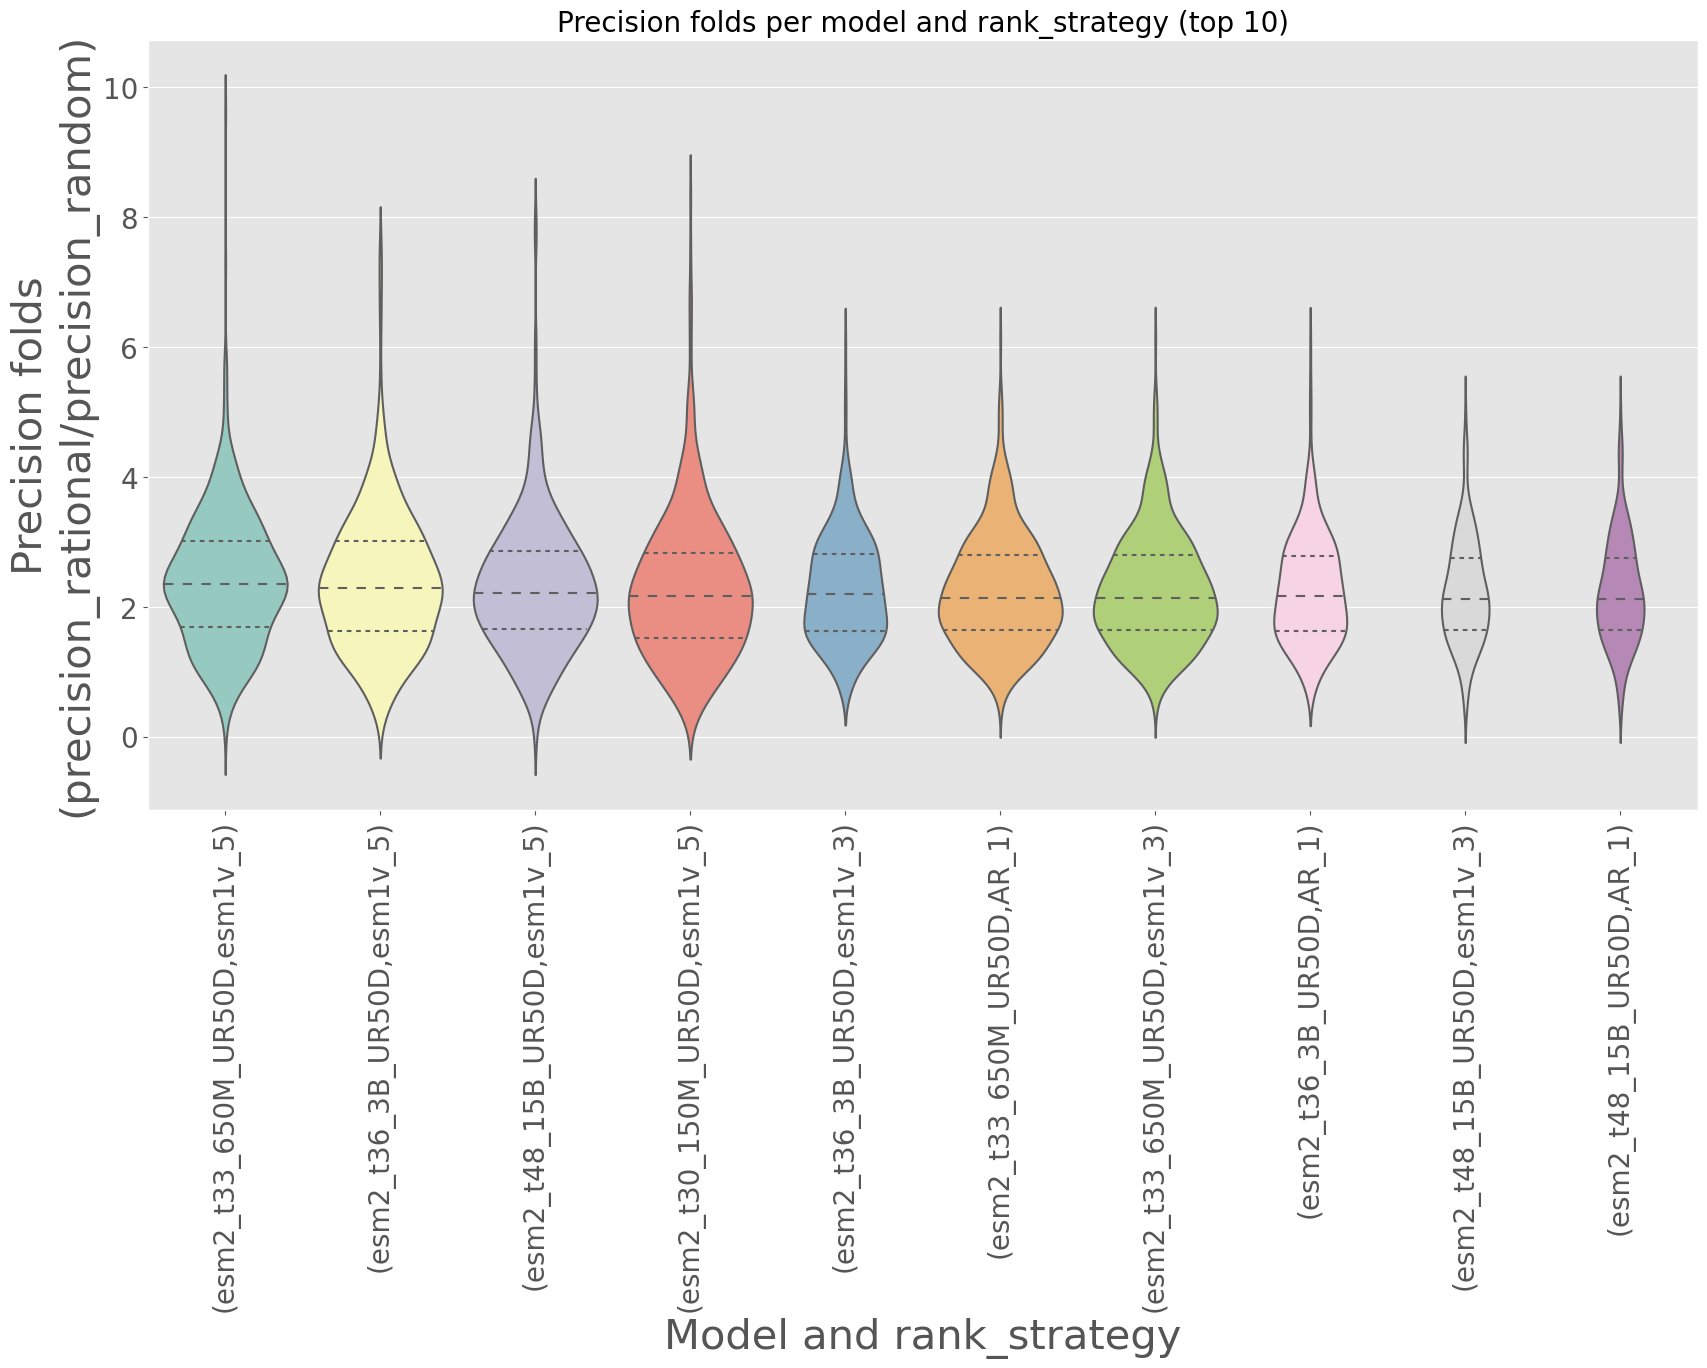

In [28]:

plt.style.use("ggplot")

# plot violin for precision_folds
fig, ax = plt.subplots(figsize=(20, 10))

sns.violinplot(merged_df, x="plot_x", y="precision_folds", split=True, inner="quartile", palette="Set3", scale="count", scale_hue=False, ax=ax, order=per_model_strategy_group["plot_x"].values[:10])
# xticks rotate 90
plt.xticks(rotation=90, fontsize=20)
plt.xlabel("Model and rank_strategy", fontsize=30)
plt.ylabel("Precision folds\n(precision_rational/precision_random)", fontsize=30)
plt.yticks(fontsize=20)
plt.title("Precision folds per model and rank_strategy (top 10)", fontsize=20)
plt.savefig("3_figs/precisionfolds_per_model_strategy_violin.png", bbox_inches='tight')
plt.savefig("3_figs/precisionfolds_per_model_strategy_violin.pdf", bbox_inches='tight')
